The goal of this blog series is to understand the state-of-art object detection algorithm, called YOLO (you only look once). Allegedly, Andrew Ng mentioned that YOLO is the best object detection algorithm in his course:

In [1]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/6ykvU9WuIws?start=340", width=990/2, height=800/2)

I will go into Yolo's model architecture and input/output encoding procedure in later posts [BLAHBLAH]().


The focus of this blog is to understand the distribution of the bounding box shape that we will later model with Yolo. The understanding of the bounding box shape distribution will later be very important to define important "Anchor box" hyperparameters in Yolo training. 

### Anchor box
Yolo uses an idea of "Anchor box" to wisely detect multiple objects, lying in close neighboorhood. 

<a data-flickr-embed="true"  href="https://www.flickr.com/photos/157237655@N08/46466533461/in/datetaken-public/" title="Screen Shot 2018-12-25 at 7.32.35 PM"><img src="https://farm8.staticflickr.com/7876/46466533461_d18c10387a_b.jpg" width="1024" height="976" alt="Screen Shot 2018-12-25 at 7.32.35 PM"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>
Example: two objects (a person and a boat) are in close neighboorhood.

Yolo requires users to predefine 
- (1) the number of anchor boxs and 
- (2) their shapes

so that multiple objects lying in close neighboorhood can be assigned to different anchor boxes. 

For example, you may predefine that there are two anchor boxes, and their specializations are such that:

- the 1st anchor box specializes small flat rectangle bounding box
- the 2nd anchor box specializes small tall rectangle bounding box
- the 3rd anchor box specializes large flat rectangle bounding box
- the 4th anchor box specializes large tall rectangle bounding box

Then for the example above, the anchor box 2 may captuers the person object and anchor box 3 may capture the boat. 


In order to pre-specify the number of anchor boxes and their shapes, Yolo proposes to use K-means clustering algorithm on bounding box shape. This blog will run K-means algorithm on the VOC2012 dataset to find good hyperparameters for Yolo. 



## VOC2012
Data can be downloaded from [Visual Object Classes Challenge 2012 (VOC2012)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#data)

This data was [previously](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html) analyzed to demonstrate RCNN, one of the common object detection techiniques.
Please see [this blog](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html)
for its descriptive statistics.
The data contains the following object classes:

In [2]:
LABELS = ['train',     'horse', 'car',  'chair',       'sofa',
          'aeroplane', 'boat',  'bus',  'pottedplant', 'cow',
          'sheep',     'dog',   'hand', 'bicycle',     'head',
          'bottle',    'cat',   'foot', 'tvmonitor',   'diningtable',
          'motorbike', 'person','bird']

I downloaded data at:

In [3]:
train_image_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/Annotations/"

## Reference
- [k-means clustering for anchor boxes](https://lars76.github.io/object-detection/k-means-anchor-boxes/#references)

- [You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf) 

- [YOLO9000:Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf)

## Reference in my blog
- [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html)

- [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)

- [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model and loss](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2014_data_model_and_loss.html)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
%matplotlib inline

To preprocess the annotations, I will use the pre-processing code  at [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2).

In [5]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
- Each element of the train_image is a dictionary containing the annoation infomation of an image.
- seen_train_labels is the dictionary containing 
  -  (key, value) = (the object class, the number of objects found in the images)

In [6]:
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


#### Output : train_image

In [7]:
train_image[:2]

[{'filename': '../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg',
  'height': 500,
  'object': [{'name': 'person',
    'xmax': 349,
    'xmin': 174,
    'ymax': 351,
    'ymin': 101},
   {'name': 'head', 'xmax': 209, 'xmin': 169, 'ymax': 146, 'ymin': 104},
   {'name': 'hand', 'xmax': 297, 'xmin': 278, 'ymax': 233, 'ymin': 210},
   {'name': 'foot', 'xmax': 297, 'xmin': 273, 'ymax': 354, 'ymin': 333},
   {'name': 'foot', 'xmax': 340, 'xmin': 319, 'ymax': 326, 'ymin': 307}],
  'width': 486},
 {'filename': '../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg',
  'height': 281,
  'object': [{'name': 'aeroplane',
    'xmax': 375,
    'xmin': 104,
    'ymax': 183,
    'ymin': 78},
   {'name': 'aeroplane', 'xmax': 197, 'xmin': 133, 'ymax': 123, 'ymin': 88},
   {'name': 'person', 'xmax': 213, 'xmin': 195, 'ymax': 229, 'ymin': 180},
   {'name': 'person', 'xmax': 44, 'xmin': 26, 'ymax': 238, 'ymin': 189}],
  'width': 500}]

#### Visualize output : seen_train_labels

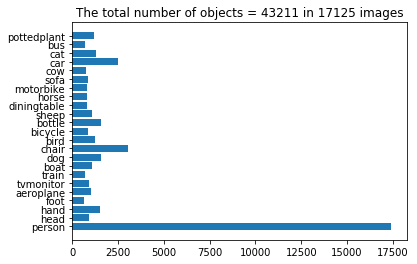

In [8]:
y_pos = np.arange(len(seen_train_labels))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.barh(y_pos,list(seen_train_labels.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(seen_train_labels.keys()))
ax.set_title("The total number of objects = {} in {} images".format(
    np.sum(list(seen_train_labels.values())),len(train_image)
))
plt.show()

## Parepare (width, height) data for K-means clustering

[YOLO9000:Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf) suggests to use clustering on bounding box shape to find the good anchor box specialization suited for the data. Here is the quote from the paper: 

<blockquote>
Dimension Clusters:
we encounter two issues with anchor boxes when using them with YOLO.
The first is that the box dimensions are hand picked. 
the network can learn to adjust the boxes appropriately but if we pick better priors for the network to start with, we can make it easier for the network to learn to predict good detections.
</blockquote>
<blockquote>
Instead of choosing priors by hand, we run k-means clustering on the training set bounding boxes to automatically find good priors. If we use standard k-means with Euclidean distance learger boxes generate more error than smaller boxes. However, what we really want are priros that lead to good IOU scores, which is indepedndent of the size of the box. Thus for our distance metric we use 1 - IOU(box,centroid)
</blockquote>
So let's first prepare feature data for K-means clustering.
The data contain width and height as its features.
I will standardize the bounding box width and hight with its image width and height as the image width and height differ across images.

In [9]:
wh = []
for anno in train_image:
    aw = float(anno['width'])  # width of the original image
    ah = float(anno['height']) # height of the original image
    for obj in anno["object"]:
        w = (obj["xmax"] - obj["xmin"])/aw # make the width range between [0,GRID_W)
        h = (obj["ymax"] - obj["ymin"])/ah # make the width range between [0,GRID_H)
        temp = [w,h]
        wh.append(temp)
wh = np.array(wh)
print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (43211, 2)


## Visualize the clustering data
It is hard to see if there is any clearly separated clusters. 

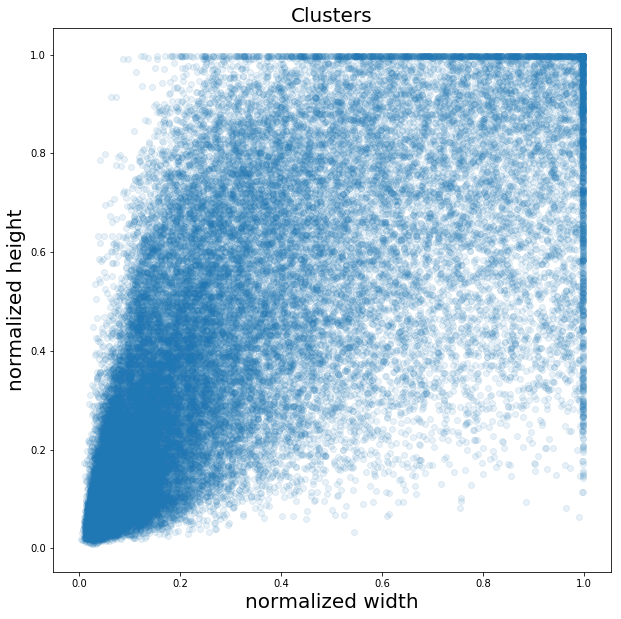

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(wh[:,0],wh[:,1],alpha=0.1)
plt.title("Clusters",fontsize=20)
plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)
plt.show()

# Intersection over union
The k-means clustering for finding the ideal anchor box specialization is well discussed with working code at [k-means clustering for anchor boxes](https://lars76.github.io/object-detection/k-means-anchor-boxes/#references). 
I feel that it is redundant to discuss the details here. So I want readers to read through this great short post.

The bounding boxes are often defined by 4 parameters: (xmin,ymin, width, height).
When we calculate IoU between two bounding boxes, all we care is their width and height.
The coordinates of a bounding box, xmin and ymin, are not of concern as we want to only compare the shapes of the bounding boxes.

In otherwords, we can think that the xmin and ymin are shared by the two objects. See the picture below:

<img src="https://farm8.staticflickr.com/7813/46412972842_6d2af063e9_h.jpg" width="300" height="400" alt="bbx">
Then the IoU can be calculated in the usual way as: 
$$\begin{array}{rl}
IoU &= \frac{\textrm{intersection} }{
\textrm{union} - \textrm{intersection}
}\\
\textrm{intersection} &= Min(w_1,w_2)  Min(h_1,h_2)\\
\textrm{union} & = w_1 h_1 + w_2  h_2
\end{array}$$

The following code is taken from [k-means clustering for anchor boxes](https://lars76.github.io/object-detection/k-means-anchor-boxes/#references) and computes the IoU.

In [11]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

## k-means clustering
The k-mean clustering has two simple steps:


Set the number of clusters and initialize the cluster centers

- Step 1: allocate each item to the closest cluster centers. 
- Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
Repeat steps 1 and 2 until the two consective iterations yield the same cluster centers. 

Note: 
- In Step 1, the distance to the cluster center is calculated using 1 - IOU
- In Step 2, I used median to calculate the cluster centers. 


The following code is mostly the same as  [k-means clustering for anchor boxes](https://lars76.github.io/object-detection/k-means-anchor-boxes/#references). 
The only change I made is the line 21 as lars76's code loop through the cases rather than the objects, which made the code substantially slower when N cases >> N clusters. 

In [12]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances



## Run the k-means clustering codes with k = 2, 3, 4,...,11.
We need to decide how many anchor boxes we should create and the specialization of each anchor boxshapes. 
To find answer to these hyperparameter values, I will run k-means clustering for k = 2,3,...,11.

The more clusters, the larger mean IoU becomes. This is expected as in ultimate case, when k = N cases, then the mean IoU must be 1. 

In [13]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4521
 3 clusters: mean IoU = 0.5299
 4 clusters: mean IoU = 0.5715
 5 clusters: mean IoU = 0.5925
 6 clusters: mean IoU = 0.6169
 7 clusters: mean IoU = 0.6349
 8 clusters: mean IoU = 0.6471
 9 clusters: mean IoU = 0.6623
10 clusters: mean IoU = 0.6774


### Visualization of k-means results 

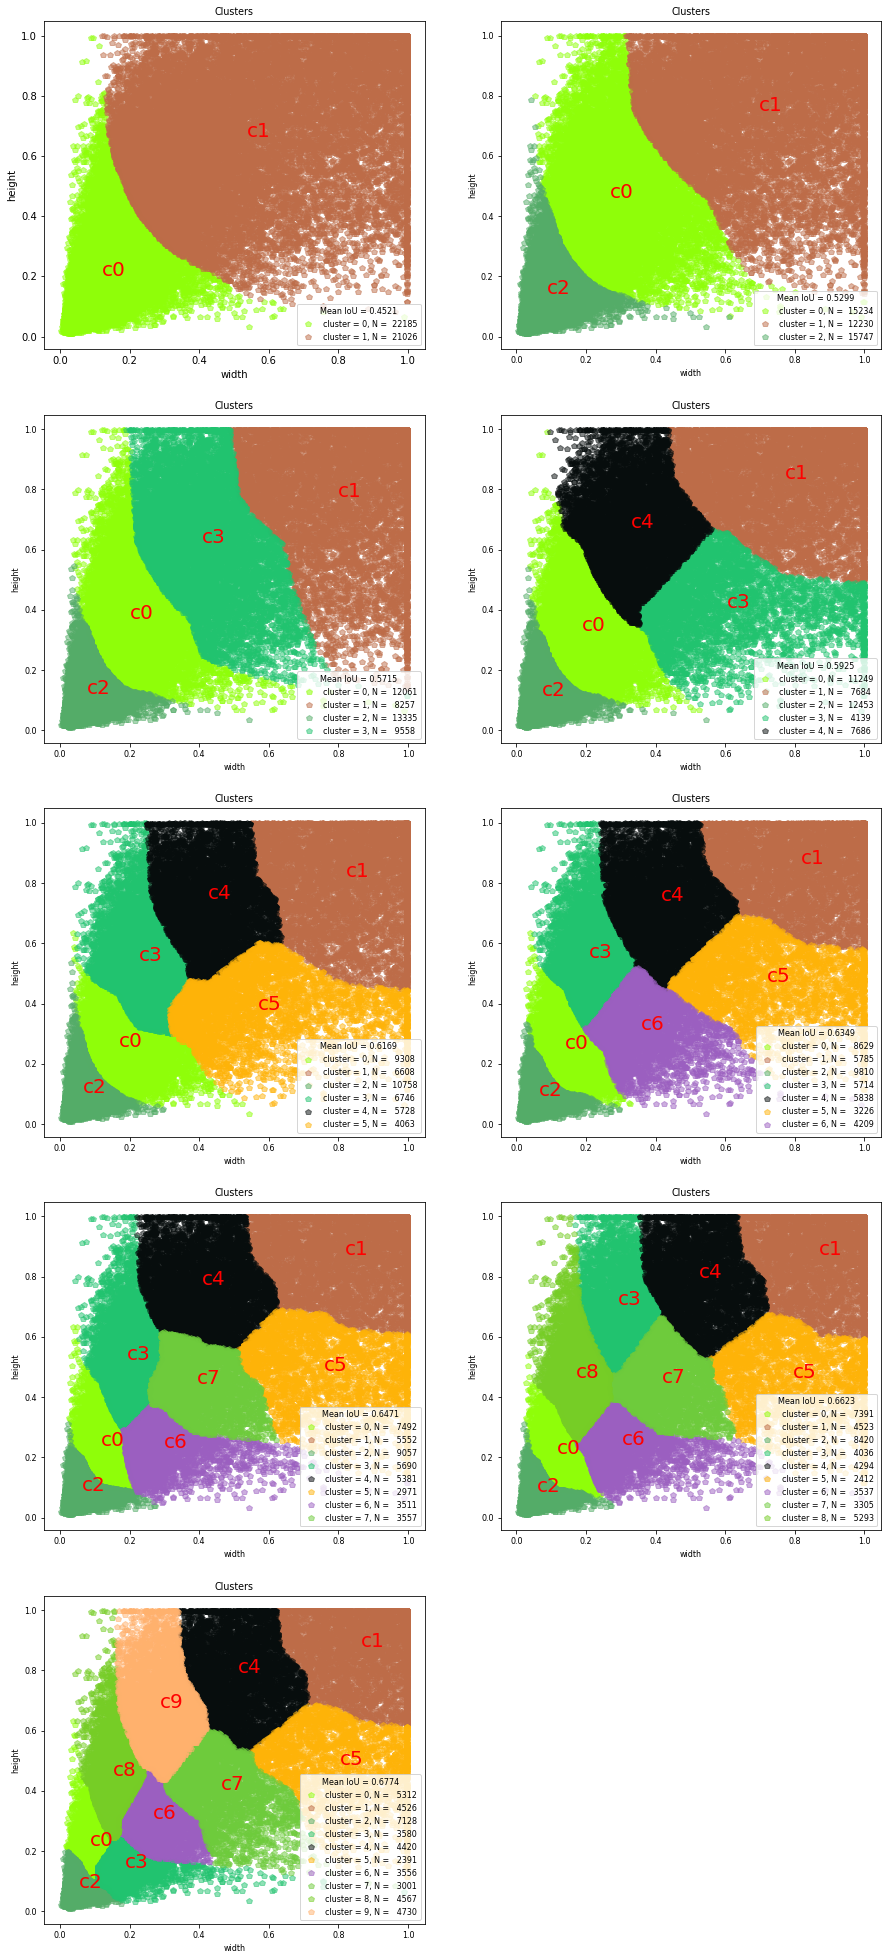

In [14]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh)
    count += 1
plt.show()

To make a decision on how many anchor boxes to use, Statisticians often like to see "elbow" curve, in this case, mean IoU vs N cluster plot. More sophisticated approach is to use [GAP statistics](https://statweb.stanford.edu/~gwalther/gap). 
The idea is that the true number of clusters is captuered when the increase in the mean IoU slope is "substantially" large. 
In this case, I would say that 4 anchor boxes may be a good size.

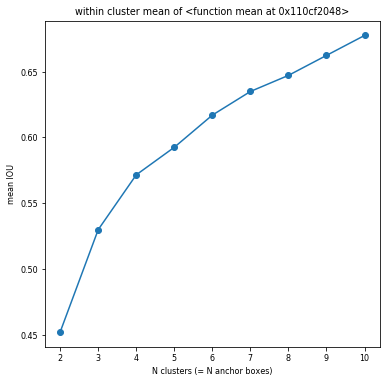

In [15]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()


# The selected anchor box shapes 

In [16]:
Nanchor_box = 4
results[Nanchor_box]["clusters"]


array([[0.20183967, 0.36878518],
       [0.79970357, 0.77402036],
       [0.07785199, 0.12090509],
       [0.40903943, 0.62087068]])